# Manage Capacities

This notebook is used to call the Azure Management API and start/pause capacities. 

### Cell 1
We will use a Service Principal to connect to the Azure API, for which we need to retrieve the details as well as other information on the subscription and capacity. In this example, the variables are retrieved from an Azure KeyVault. If you are also using a KeyVault, please replace the KeyVault IDs with your own to retrieve the correct information. If you don't use a KeyVault, you can otherwise assign the correct values to the variables. You will need the following details: 
- For authentication:
  - Service Principal ID (Client ID)
  - Service Principal Secret (Client Secret)
  - Your Tenant ID
- To connect to the capacity using the API:
  - Your Subscription ID
  - The Resource Group name
  - The Capacity name

Once authenticated, the capacity API is called to check the current state of the capacity.

Please make sure, that the Service Principal has Contributor access on the capacity. 

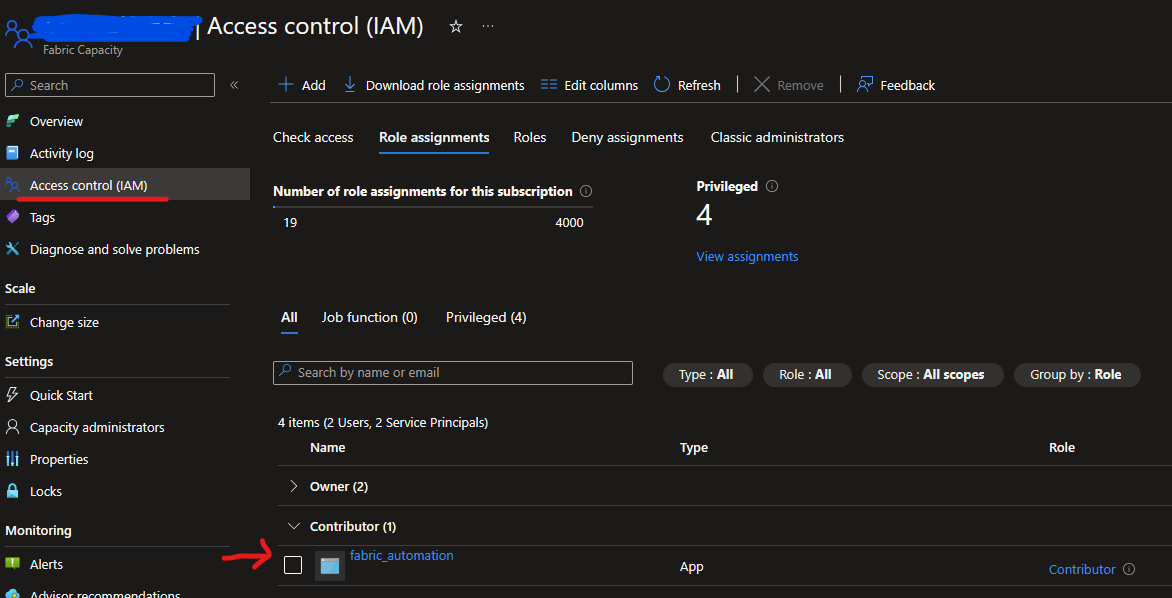

### Cell 2
If the capacity is not paused, the API is called to suspend (pause) the capacity. 

You could also use the [Power BI APIs](https://learn.microsoft.com/en-us/rest/api/power-bi-embedded/capacities/suspend?view=rest-power-bi-embedded-2021-01-01) to achieve the same for Power BI Embedded capacities

### Cell 3
Frozen cell that includes the code to test resume / suspend of the capacity. 

In [ ]:
####################################
# Retrieve variables from keyvault #
####################################
key_vault = "https://xxx.vault.azure.net/"
client_secret = mssparkutils.credentials.getSecret(key_vault, "ClientSecret") 
tenant = mssparkutils.credentials.getSecret(key_vault, "TenantId") 
client = mssparkutils.credentials.getSecret(key_vault, "ClientID")  # Client needs to have Contributor access to the capacity
subscription = mssparkutils.credentials.getSecret(key_vault, "SubscriptionId")
resourcegroup = "ResourceGroupName"
capacity = "CapacityName"


################
# Authenticate #
################
import json, requests
 
try:
    from azure.identity import ClientSecretCredential
except Exception:
     !pip install azure.identity
     from azure.identity import ClientSecretCredential
 
# Generates the access token for the Service Principal
api = 'https://management.azure.com/.default' 
auth = ClientSecretCredential(authority = 'https://login.microsoftonline.com/', 
                              tenant_id = tenant,
                              client_id = client,
                              client_secret = client_secret)
access_token = auth.get_token(api)
access_token = access_token.token
 

##################################
# Get current status of capacity #
##################################
base_url = 'https://management.azure.com/'
relative_url = 'subscriptions/' + subscription + '/resourceGroups/' + resourcegroup + '/providers/Microsoft.Fabric/capacities/' + capacity + '?api-version=2022-07-01-preview' 
header = {'Authorization': f'Bearer {access_token}'}
 
response = requests.get(base_url + relative_url, headers = header)
print('[Log] API status: ' + str(response))

response_json = json.loads(response.content)
print('[Log] Capacity State: ' + response_json['properties']['state'])

In [ ]:

##########################################
# Pause capacity if currently not paused #
##########################################
relative_url = 'subscriptions/' + subscription + '/resourceGroups/' + resourcegroup + '/providers/Microsoft.Fabric/capacities/' + capacity + '/suspend?api-version=2022-07-01-preview'

if response_json['properties']['state'] != 'Paused' :
    print('[Log] Pausing capacity')
    response = requests.post(base_url + relative_url, headers = header)
    print('[Log] API status: ' + str(response))
else :
    print('[Log] Capacity already paused')

In [ ]:
########################
# Start/Pause capacity #
# For start: resume    #
# For pause: suspend   #
########################
action = "resume"
relative_url = 'subscriptions/' + subscription + '/resourceGroups/' + resourcegroup + '/providers/Microsoft.Fabric/capacities/' + capacity + '/' + action + '?api-version=2022-07-01-preview'
response = requests.post(base_url + relative_url, headers = header)
print('[Log] API status: ' + str(response))

#### Attribution
Thank you to Darren Gosbell for a great [blog post](https://darren.gosbell.com/2023/06/calling-a-power-bi-rest-api-from-a-fabric-notebook/) on how to call an API from a Fabric Notebook. 